# IT - 550 Information Retrieval Assignment - 7
### Student ID - 202011032

## Importing libraries and setting paths

In [1]:
import os
import re
import string
import nltk
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

PATH_BASE = "jigsaw-toxic-comment-classification-challenge"
PATH_TRAIN = os.path.join(PATH_BASE, "train.csv")
PATH_TEST = os.path.join(PATH_BASE, "test.csv")
PATH_TEST_LABELS = os.path.join(PATH_BASE, "test_labels.csv")

## Loading and Exploring Train and Test Data

In [2]:
train_df = pd.read_csv(PATH_TRAIN)
test_df = pd.read_csv(PATH_TEST)

In [3]:
train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


394.0732213246768 590.7202819048923 5000


<AxesSubplot:>

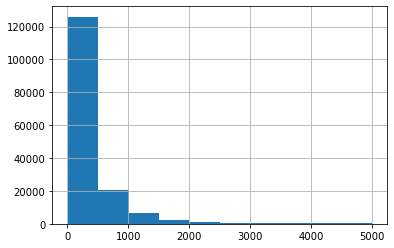

In [4]:
lengths = train_df.comment_text.str.len()
print(lengths.mean(), lengths.std(), lengths.max())
lengths.hist()

Adding a *none* label to identify comments with no labels.

In [5]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_df['none'] = 1 - train_df[labels].max(axis=1)
train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,1


In [6]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Fill empty comment texts from train and test sets

In [7]:
train_df['comment_text'].fillna('unknown', inplace=True)
test_df['comment_text'].fillna('unknown', inplace=True)

## Performing Text classification of comments using Linear SVM with TF-IDF representation for the comments
Creating a *term-document matrix* representation with the help of `sklearn` library and building a *pipeline* for Tfidf representation and Linear SVM model for classification.

In [8]:
def tokenize(s):
    regexp_token = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
    return regexp_token.sub(r' \1 ', s).split()

Build a pipeline from TfidfVectorizer and combination of LinearSVC & MultiOutputClassifier for multilabel classification

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
# from sklearn.linear_model import SGDClassifier
# nltk.download()

# Adding a stemmer to the TfidfVectorizer pipeline
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        stemmer = nltk.stem.snowball.SnowballStemmer("english")
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

multilabel_svm = MultiOutputClassifier(LinearSVC(random_state=23), n_jobs=-1)

text_clsfn_tfidf_svm = Pipeline([
    ('tfidf', StemmedTfidfVectorizer(tokenizer=tokenize, stop_words='english', strip_accents='unicode', sublinear_tf=True)),
    ('clsfn_svm', multilabel_svm),
])

Train the Linear SVM Classifier Pipeline and Predict on test comments data

In [11]:
# preds_tfidf_svm = np.zeros((len(test_df), len(labels)))
# for i, j in enumerate(labels):
#     print('fit', j)
#     _ = text_clsfn_tfidf_svm.fit(train_df['comment_text'], train_df[j])
#     preds_tfidf_svm[:,i] = text_clsfn_tfidf_svm.predict(test_df['comment_text'])

_ = text_clsfn_tfidf_svm.fit(train_df['comment_text'], train_df[labels])
preds_tfidf_svm = text_clsfn_tfidf_svm.predict(test_df['comment_text'])

In [12]:
# Generating dataframe for predicted labels in the format of sample_submission.csv
test_labels = pd.read_csv(PATH_TEST_LABELS)
preds_tfidf_svm_df = pd.DataFrame({'id': test_df['id']})
preds_tfidf_svm_df = pd.concat([preds_tfidf_svm_df, pd.DataFrame(preds_tfidf_svm, columns=labels)], axis=1)

Plotting confusion matrix of the predicted labels with the groundtruth labels

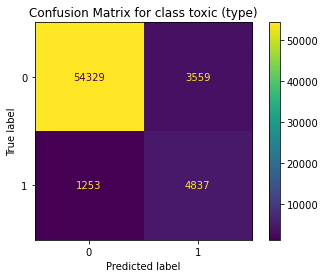

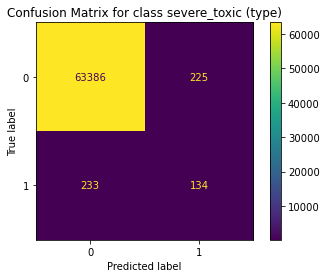

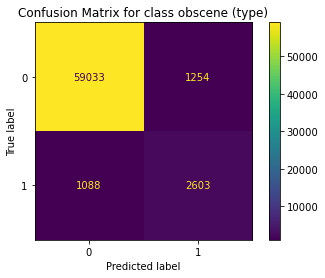

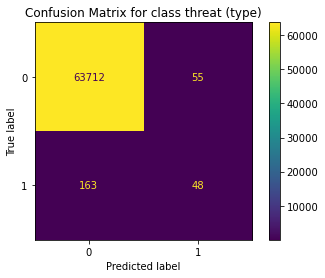

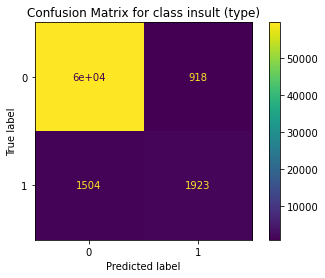

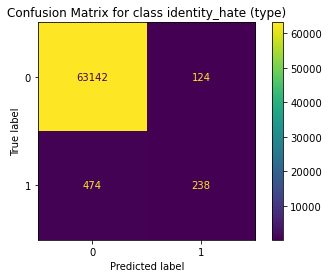

In [13]:
import matplotlib.pyplot as plt

test_labels_filtered = test_labels.drop(test_labels[test_labels[labels].values == -1].index)
preds_tfidf_svm_df_filtered = preds_tfidf_svm_df[preds_tfidf_svm_df.id.isin(test_labels_filtered.id)]

# Generate multiclass confusion matrices
matrices = multilabel_confusion_matrix(
    test_labels_filtered[labels], preds_tfidf_svm_df_filtered[labels],
)

# Plotting matrices: code
for i, label in enumerate(labels):
    cmd = ConfusionMatrixDisplay(matrices[i]).plot()
    plt.title(f'Confusion Matrix for class {label} (type)')
    plt.show()


**Micro and macro precision, recall, f1-score using TF-IDF representation**

In [18]:
from sklearn.metrics import classification_report, accuracy_score

print("Overall:")
print(classification_report(test_labels_filtered[labels], preds_tfidf_svm_df_filtered[labels], target_names=labels))

print("-------------------------------------------------------")

for label in labels:
    print(f"For class {label}:")
    print(classification_report(test_labels_filtered[label], preds_tfidf_svm_df_filtered[label]))

Overall:
               precision    recall  f1-score   support

        toxic       0.58      0.79      0.67      6090
 severe_toxic       0.37      0.37      0.37       367
      obscene       0.67      0.71      0.69      3691
       threat       0.47      0.23      0.31       211
       insult       0.68      0.56      0.61      3427
identity_hate       0.66      0.33      0.44       712

    micro avg       0.61      0.67      0.64     14498
    macro avg       0.57      0.50      0.51     14498
 weighted avg       0.62      0.67      0.64     14498
  samples avg       0.07      0.06      0.06     14498

-------------------------------------------------------
For class toxic:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     57888
           1       0.58      0.79      0.67      6090

    accuracy                           0.92     63978
   macro avg       0.78      0.87      0.81     63978
weighted avg       0.94      0.92     

## Performing Text classification of comments using Linear SVM with Word2Vec representation for the comments
Creating a *term-document matrix* representation with the help of `gensim` library and building a *pipeline* for Tfidf representation and Linear SVM model for classification.

In [22]:
from gensim import models
from gensim.parsing.preprocessing import preprocess_string

comments = train_df['comment_text'].apply(preprocess_string)

Training Word2Vec skipgram model from the train data comments

In [26]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Using skipgram word2vec model
word2vec_sg_model = models.Word2Vec(sentences=comments, size=300, window=10, min_count=1, sg=1, hs=1, negative=0)

2021-03-23 22:13:38,692 : INFO : collecting all words and their counts
2021-03-23 22:13:38,693 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-03-23 22:13:38,757 : INFO : PROGRESS: at sentence #10000, processed 300846 words, keeping 25523 word types
2021-03-23 22:13:38,814 : INFO : PROGRESS: at sentence #20000, processed 599397 words, keeping 38766 word types
2021-03-23 22:13:38,868 : INFO : PROGRESS: at sentence #30000, processed 891187 words, keeping 49730 word types
2021-03-23 22:13:38,922 : INFO : PROGRESS: at sentence #40000, processed 1194652 words, keeping 59465 word types
2021-03-23 22:13:38,977 : INFO : PROGRESS: at sentence #50000, processed 1487857 words, keeping 68300 word types
2021-03-23 22:13:39,034 : INFO : PROGRESS: at sentence #60000, processed 1797168 words, keeping 76616 word types
2021-03-23 22:13:39,088 : INFO : PROGRESS: at sentence #70000, processed 2097425 words, keeping 84553 word types
2021-03-23 22:13:39,147 : INFO : PROGRESS:

In [35]:
# Helper function to generate vectors for docs or sentences from a given Word2Vec model
def docvec_from_wordvec(docs, wordvec_model=None):
    doc_vecs = []
    for doc in docs:
        doc_vec = np.zeros((wordvec_model.wv.vectors.shape[1],))
        vectors_added = 0
        for token in doc:
            try:
                doc_vec += wordvec_model.wv.get_vector(token)
                vectors_added += 1
            except:
                continue
        if vectors_added != 0:
            doc_vec = doc_vec / vectors_added
        doc_vecs.append(doc_vec)
    
    return np.array(doc_vecs)

Build vectors for comments and train the classifier model using those vectors

In [36]:
comment_vecs = docvec_from_wordvec(comments, word2vec_sg_model)
print(comment_vecs.shape)

(159571, 300)


In [37]:
multilabel_svm.fit(comment_vecs, train_df[labels])

MultiOutputClassifier(estimator=LinearSVC(random_state=23), n_jobs=-1)

Predict the test comments data using the trained model

In [38]:
test_comments = test_df['comment_text'].apply(preprocess_string)
test_comment_vecs = docvec_from_wordvec(test_comments, word2vec_sg_model)
print(test_comment_vecs.shape)

(153164, 300)


In [39]:
preds_word2vec_svm = multilabel_svm.predict(test_comment_vecs)
print(preds_word2vec_svm)

[[1 0 1 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]]


In [45]:
# Create dataframe in the format of sample_submission.csv
preds_word2vec_svm_df = pd.DataFrame({'id': test_df['id']})
preds_word2vec_svm_df = pd.concat([preds_word2vec_svm_df, pd.DataFrame(preds_word2vec_svm, columns=labels)], axis=1)

# Use test_labels_filtered created in above cells
preds_word2vec_svm_df_filtered = preds_word2vec_svm_df[preds_word2vec_svm_df.id.isin(test_labels_filtered.id)]

Plotting confusion matrix of the predicted labels with the groundtruth labels

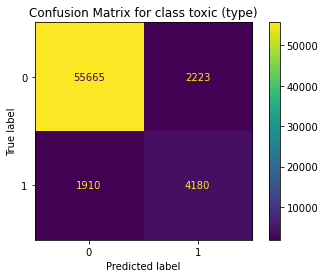

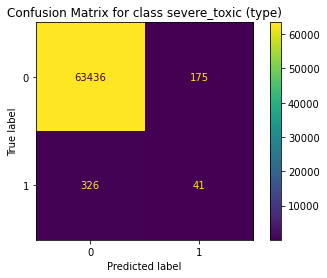

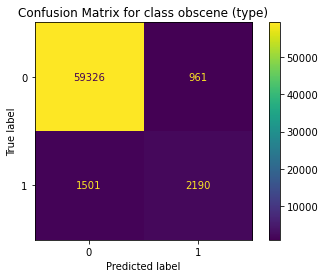

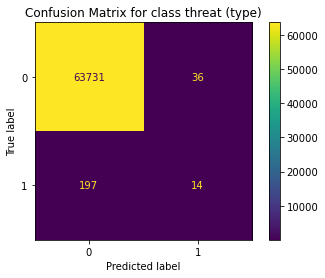

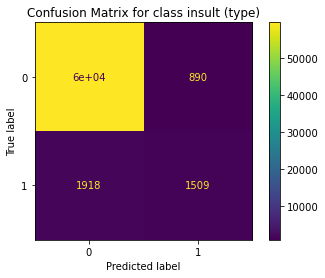

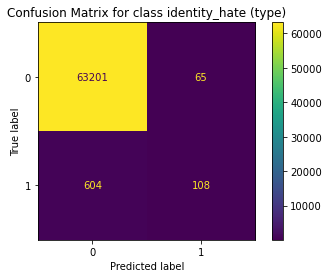

In [46]:
# Generate multiclass confusion matrices
matrices = multilabel_confusion_matrix(
    test_labels_filtered[labels], preds_word2vec_svm_df_filtered[labels],
)

# Plotting matrices: code
for i, label in enumerate(labels):
    cmd = ConfusionMatrixDisplay(matrices[i]).plot()
    plt.title(f'Confusion Matrix for class {label} (type)')
    plt.show()


**Micro and macro precision, recall, f1-score using Word2Vec representation**

In [47]:
print("Overall:")
print(classification_report(test_labels_filtered[labels], preds_word2vec_svm_df_filtered[labels], target_names=labels))

print("-------------------------------------------------------")

for label in labels:
    print(f"For class {label}:")
    print(classification_report(test_labels_filtered[label], preds_word2vec_svm_df_filtered[label]))

Overall:
               precision    recall  f1-score   support

        toxic       0.65      0.69      0.67      6090
 severe_toxic       0.19      0.11      0.14       367
      obscene       0.70      0.59      0.64      3691
       threat       0.28      0.07      0.11       211
       insult       0.63      0.44      0.52      3427
identity_hate       0.62      0.15      0.24       712

    micro avg       0.65      0.55      0.60     14498
    macro avg       0.51      0.34      0.39     14498
 weighted avg       0.64      0.55      0.58     14498
  samples avg       0.06      0.05      0.05     14498

-------------------------------------------------------
For class toxic:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     57888
           1       0.65      0.69      0.67      6090

    accuracy                           0.94     63978
   macro avg       0.81      0.82      0.82     63978
weighted avg       0.94      0.94     

## Final micro and macro precision, recall, f1-score for TF-IDF and Word2Vec with Linear SVM approaches

In [48]:
print("Overall:")
print("TF-IDF -")
print(classification_report(test_labels_filtered[labels], preds_tfidf_svm_df_filtered[labels], target_names=labels))
print("\nWord2Vec -")
print(classification_report(test_labels_filtered[labels], preds_word2vec_svm_df_filtered[labels], target_names=labels))

print("-------------------------------------------------------")

for label in labels:
    print(f"For class {label}:")
    print("TF-IDF -")
    print(classification_report(test_labels_filtered[label], preds_tfidf_svm_df_filtered[label]))
    print("\nWord2Vec -")
    print(classification_report(test_labels_filtered[label], preds_word2vec_svm_df_filtered[label]))

Overall:
TF-IDF -
               precision    recall  f1-score   support

        toxic       0.58      0.79      0.67      6090
 severe_toxic       0.37      0.37      0.37       367
      obscene       0.67      0.71      0.69      3691
       threat       0.47      0.23      0.31       211
       insult       0.68      0.56      0.61      3427
identity_hate       0.66      0.33      0.44       712

    micro avg       0.61      0.67      0.64     14498
    macro avg       0.57      0.50      0.51     14498
 weighted avg       0.62      0.67      0.64     14498
  samples avg       0.07      0.06      0.06     14498


Word2Vec -
               precision    recall  f1-score   support

        toxic       0.65      0.69      0.67      6090
 severe_toxic       0.19      0.11      0.14       367
      obscene       0.70      0.59      0.64      3691
       threat       0.28      0.07      0.11       211
       insult       0.63      0.44      0.52      3427
identity_hate       0.62      0